In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Funnynet

## A neural network that makes jokes

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

In [2]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math, random

In [9]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [12]:
files = list(PATH.iterdir())
print(files)

[PosixPath('data/reddit_jokes.json'), PosixPath('data/stupidstuff.json')]


In [13]:
for fname in files:
    if "eddit" in str(fname):
        reddit_dataset = str(fname)
    if "upid" in str(fname):
        stupid_dataset = str(fname)
reddit_jokes = json.load(open(reddit_dataset))
stupid_jokes = json.load(open(stupid_dataset))

In [14]:
len(reddit_jokes)

194553

In [15]:
reddit_jokes[0]

{'body': 'Now I have to say "Leroy can you please paint the fence?"',
 'id': '5tz52q',
 'score': 1,
 'title': 'I hate how you cant even say black paint anymore'}

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [16]:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

In [17]:
len(rated_jokes)

132992

In [18]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

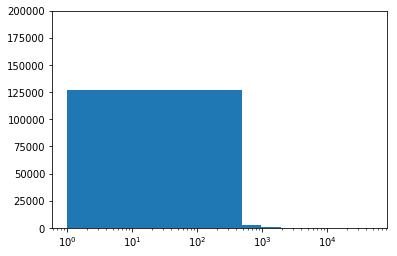

In [15]:
low_scores = [score for score in scores]
plt.xscale('log', nonposx='clip')
plt.ylim(ymax=200000)
#plt.axes.set_ylim([0,200000])
plt.hist(low_scores, bins=100);

In [19]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

'I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"'

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string, using the `EOJ` tag.

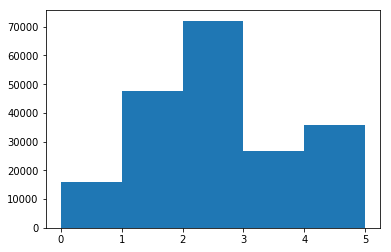

In [17]:
all_jokes = []
for i in range(len(reddit_jokes)):
    r_joke = reddit_jokes[i]
    r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
    if r_joke['rating']>5: # TODO: use max() here
        r_joke['rating']=5
    del r_joke['score'] 
    r_joke['body'] = r_joke['title']+" "+r_joke['body']
    del r_joke['title']
for s_joke in stupid_jokes:
    del s_joke['category']

combined = [joke['rating'] for joke in reddit_jokes]
combined = combined + [joke['rating'] for joke in stupid_jokes]
plt.hist(combined,bins=5);

combined_jokes = reddit_jokes + stupid_jokes

title_body = [joke['body']+' ' for joke in combined_jokes]

In [20]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 800000: 
        break

In [22]:
len(text)
print(text[1000:1100])

hit me, not that they were going to destroy the housing market 20 years later. xeoj  My boss said to


In [26]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)
chars.insert(0, "\0")
print(chars)

total chars: 127
['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'ʖ', '͜', '͡', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'ʖ', '͜', '͡', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


It appears there are Emojis in the dataset. 

In [27]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [28]:
idx = [char_indices[c] for c in text]

idx[:10]

[3, 44, 3, 75, 68, 87, 72, 3, 75, 82]

In [29]:
''.join(indices_char[i] for i in idx[:70])

' I hate how you cant even say black paint anymore Now I have to say "L'

Partitioning the dataset and writing it to /data/trn/trn.txt and /data/val/val.txt

In [30]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH} # Don't do this, use pathlib(), it's a lot cleaner

reddit_jokes.json  stupidstuff.json


In [32]:
trn = open(TRN+"trn.txt","w")
trn.write("test")
trn.write(str(idx[0:int(len(idx)*2/3)]))
trn.close()
val = open(VAL+"val.txt","w")
val.write("test")
val.write(str(idx[int(len(idx)*2/3):len(idx)-1]))
val.close()

## Three character model

In [33]:
len(idx)

800120

In [34]:
cs = 3
c1_data = c2_data = c3_data = c4_data = []
for i in range(0, len(idx)-cs, cs):
    c1_data.append(idx[i])
    c2_data.append(idx[i+1])
    c3_data.append(idx[i+2])
    c4_data.append(idx[i+3])

### Create the input and outputs of our RNN

In [35]:
x1 = np.stack(c1_data)
x2 = np.stack(c2_data)
x3 = np.stack(c3_data)
y  = np.stack(c4_data)

### Create and train model

In [37]:
n_hidden = 256
embeddings_sz = 42 #size of embeddings matrix

In [38]:
# These libraries require some setup, try the pip install git+https.github.com/... trick
from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

In [39]:
class ThreeCharRNN(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1))) # Why relu?
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))

In [40]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

In [41]:
model = ThreeCharRNN(vocab_size, embeddings_sz).cuda()

In [42]:
train_iterator = iter(md.trn_dl)
*xs,yt = next(train_iterator)
t = model(*V(xs))

In [43]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [45]:
fit(model, md, n_epochs=1, opt=optimizer, crit=F.nll_loss) # The negative log likelihood loss

epoch      trn_loss   val_loss                                    
    0      0.002471   2e-06     



[array([0.])]

In [47]:
set_lrs(optimizer, 0.001)

In [49]:
fit(model, md, 1, optimizer, F.nll_loss)

epoch      trn_loss   val_loss                                    
    0      0.000195   6e-06     



[array([0.00001])]

In [52]:
# TODO: what is going on with the indentation here? Use 4 spaces, not 3

# def get_next(input):
#     running_indicies = [] # Use get_next_n() here
#     indicies = []
#     for char in input:
#         running_indicies.append(char_indices[char])
#     for i in range(10):
#         indicies = np.array(running_indicies[-3:])
#         indicies = T(indicies)
#        prediction = model(*VV(indicies))
#        pred_idx = np.argmax(to_np(prediction))
#        running_indicies.append(pred_idx)
#    result_chars = []
#    for index in running_indicies:
#        result_chars.append(chars[index])
#    return result_chars


def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = model(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [53]:
get_next('y. ')

' '

In [54]:
get_next('the')

'e'

In [55]:
get_next('blo')

'o'

### Let's create a bigger RNN!

In [57]:
rnn_len=8

In [59]:
# char_in_jokes = [[idx[i+j] for i in range(rnn_len)] for j in range(len(idx)-rnn_len)]
# The above line and the below for loops are the same, just refactored to be easier to read

char_input = []
for j in range(len(idx)-rnn_len):
    tmp = []
    for i in range(rnn_len):
        tmp.append(idx[i+j])
    char_input.append(tmp)

In [60]:
char_output = []
for j in range(len(idx)-rnn_len):
    char_output.append(idx[j+rnn_len])

In [61]:
xs = np.stack(char_input, axis=0)

In [62]:
xs.shape

(800112, 8)

In [63]:
y = np.stack(char_output)
y.shape

(800112,)

In [64]:
xs[:rnn_len,:rnn_len]

array([[ 3, 44,  3, 75, 68, 87, 72,  3],
       [44,  3, 75, 68, 87, 72,  3, 75],
       [ 3, 75, 68, 87, 72,  3, 75, 82],
       [75, 68, 87, 72,  3, 75, 82, 90],
       [68, 87, 72,  3, 75, 82, 90,  3],
       [87, 72,  3, 75, 82, 90,  3, 92],
       [72,  3, 75, 82, 90,  3, 92, 82],
       [ 3, 75, 82, 90,  3, 92, 82, 88]])

In [65]:
len(y[:rnn_len])

8

In [66]:
val_idx = get_cv_idxs(len(idx)-rnn_len-1)
# val_idx.shape

In [67]:
model_data = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [68]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
#         pdb.set_trace()
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
            
        return F.log_softmax(self.l_out(h), dim=-1)

In [69]:
model = CharLoopModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(model.parameters(), 1e-2)

In [71]:
fit(model, model_data, n_epochs=1, opt=opt, crit=F.nll_loss)

epoch      trn_loss   val_loss                                
    0      2.094388   2.088229  



[array([2.08823])]

In [72]:
set_lrs(opt, 0.001)

In [74]:
fit(model, model_data, n_epochs=1, opt=opt, crit=F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.836378   1.834439  



[array([1.83444])]

In [75]:
get_next('for thos')

'e'

In [79]:
get_next(' a blond')

'e'

In [80]:
get_next('into a b')

'e'

In [81]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [82]:
get_next_n('into a b', 40)

'into a been the says a for the says a for the sa'

In [83]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.l_in = nn.Linear(embeddings_sz+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in rnn_len:
            inp = torch.cat((h, self.e(c)), 1)
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [84]:
m = CharLoopConcatModel(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [85]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [86]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                    
    0      0.000454   0.000239  



[array([0.00024])]

In [87]:
set_lrs(opt, 1e-4)

In [88]:
fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                    
    0      0.000124   0.00018   



[array([0.00018])]

### Test model

In [89]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [90]:
get_next('wome')

'o'

In [91]:
get_next('beca')

'e'

In [92]:
get_next('char')

'h'

### RNN with pytorch

### Model with Multiple Outputs

In [94]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        #print("rnn_len: "+str(rnn_len))
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [95]:
m = CharRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [96]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [97]:
t = m.e(V(torch.stack(xs)))
t.size()

torch.Size([3, 512, 42])

In [98]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

(torch.Size([3, 512, 256]), torch.Size([1, 512, 256]))

In [99]:
t = m(*V(xs)); t.size()

torch.Size([512, 127])

In [100]:
fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                                    
    0      0.00056    0.000258  
    1      0.00024    4.6e-05                                     
    2      1.8e-05    1.3e-05                                     
    3      2e-06      4e-06                                       



[array([0.])]

In [101]:
set_lrs(opt, 1e-4)

In [102]:
fit(m, md, 2, opt, F.nll_loss)

epoch      trn_loss   val_loss                                    
    0      2e-06      4e-06     
    1      1e-06      2e-06                                       



[array([0.])]

### Test model

In [103]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [104]:
get_next('for thos')

'o'

In [105]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [106]:
get_next_n('for thos', 40)

'for thosoooooooooooooooooooooooooooooooooooooooo'

## Multi output model

### Setup

Let's take non-overallping sets of characters this time

In [107]:
c_in_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(0, len(idx)-rnn_len-1, rnn_len)]

In [108]:
c_out_dat = [[idx[i+j] for i in range(rnn_len)] for j in range(1, len(idx)-rnn_len, rnn_len)]

In [110]:
xs = np.stack(c_in_dat)
xs.shape

(100014, 8)

In [111]:
xs[:rnn_len,:rnn_len]

array([[ 3, 44,  3, 75, 68, 87, 72,  3],
       [75, 82, 90,  3, 92, 82, 88,  3],
       [70, 68, 81, 87,  3, 72, 89, 72],
       [81,  3, 86, 68, 92,  3, 69, 79],
       [68, 70, 78,  3, 83, 68, 76, 81],
       [87,  3, 68, 81, 92, 80, 82, 85],
       [72,  3, 49, 82, 90,  3, 44,  3],
       [75, 68, 89, 72,  3, 87, 82,  3]])

In [112]:
ys = np.stack(c_out_dat)
ys.shape

(100014, 8)

In [113]:
ys[:rnn_len,:rnn_len]

array([[44,  3, 75, 68, 87, 72,  3, 75],
       [82, 90,  3, 92, 82, 88,  3, 70],
       [68, 81, 87,  3, 72, 89, 72, 81],
       [ 3, 86, 68, 92,  3, 69, 79, 68],
       [70, 78,  3, 83, 68, 76, 81, 87],
       [ 3, 68, 81, 92, 80, 82, 85, 72],
       [ 3, 49, 82, 90,  3, 44,  3, 75],
       [68, 89, 72,  3, 87, 82,  3, 86]])

### Create and train model

In [114]:
val_idx = get_cv_idxs(len(xs)-rnn_len-1)

In [115]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [116]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, embeddings_sz):
        super().__init__()
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.RNN(embeddings_sz, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *rnn_len):
        bs = rnn_len[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(rnn_len))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)

In [117]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [118]:
it = iter(md.trn_dl)
*xst,yt = next(it)
#t = m(*V(xs))

In [119]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [120]:
fit(m, md, 4, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      2.54212    2.384332  
    1      2.240772   2.183059                              
    2      2.109145   2.080348                              
    3      2.033118   2.016263                              



[array([2.01626])]

In [121]:
set_lrs(opt, 1e-4)

In [122]:
fit(m, md, 1, opt, nll_loss_seq)

epoch      trn_loss   val_loss                             
    0      1.997236   2.002939  



[array([2.00294])]

## Identity init!

In [123]:
m = CharSeqRnn(vocab_size, embeddings_sz).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [124]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 256x256 (GPU 0)]

In [125]:
fit(m, md, 4, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      2.244507   2.137505  
    1      2.053069   2.028961                              
    2      1.980946   1.987566                              
    3      1.940639   1.951869                              



[array([1.95187])]

In [126]:
set_lrs(opt, 1e-3)

In [127]:
fit(m, md, 4, opt, nll_loss_seq)

epoch      trn_loss   val_loss                              
    0      1.860224   1.877847  
    1      1.847886   1.871097                              
    2      1.842195   1.866956                              
    3      1.835162   1.86353                               



[array([1.86353])]

## Stateful model

### Adding State: RNN

### Setup

In [128]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

In [129]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

reddit_jokes.json  stupidstuff.json  trn/  val/


Looks like this next part assumes we have already partitioned the data into trn/trn.txt and val/val.txt for training and validation sets, respectively.

In [130]:
TEXT = data.Field(lower=True, tokenize=list)
print("TEXT: "+str(TEXT))
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

TEXT: <torchtext.data.field.Field object at 0x7f0b4b471668>


(3952, 14, 1, 2024278)

In [131]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [132]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [133]:
fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                                  
    0      0.525814   0.532849  
    1      0.493108   0.5048                                    
    2      0.481015   0.494576                                  
    3      0.470392   0.482152                                  



[array([0.48215])]

In [134]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                                  
    0      0.435904   0.457091  
    1      0.431785   0.453439                                  
    2      0.426192   0.451034                                  
    3      0.430737   0.44898                                   



[array([0.44898])]

### RNN loop

In [139]:
# From the pytorch source

def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh))

In [140]:
class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [137]:
m = CharSeqStatefulRnn2(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [138]:
fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                                  
    0      0.522839   0.529669  
    1      0.490646   0.505466                                  
    2      0.476849   0.490029                                  
    3      0.471633   0.483625                                  



[array([0.48363])]

### GRU

In [141]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [119]:
# From the pytorch source code - for reference

# def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
#     gi = F.linear(input, w_ih, b_ih)
#     gh = F.linear(hidden, w_hh, b_hh)
#     i_r, i_i, i_n = gi.chunk(3, 1)
#     h_r, h_i, h_n = gh.chunk(3, 1)

#     resetgate = F.sigmoid(i_r + h_r)
#     inputgate = F.sigmoid(i_i + h_i)
#     newgate = F.tanh(i_n + resetgate * h_n)
#     return newgate + inputgate * (hidden - newgate)

In [142]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512).cuda()

opt = optim.Adam(m.parameters(), 1e-3)

In [143]:
fit(m, md, 6, opt, F.nll_loss)

epoch      trn_loss   val_loss                                  
    0      0.504086   0.514013  
    1      0.468326   0.48185                                   
    2      0.449663   0.466684                                  
    3      0.440937   0.459561                                  
    4      0.434015   0.454837                                  
    5      0.42847    0.449195                                  



[array([0.44919])]

In [122]:
set_lrs(opt, 1e-4)

In [123]:
fit(m, md, 3, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.394254   0.431735  
    1      0.391121   0.428118                                  
    2      0.386359   0.426548                                  



[0.4265484]

In [124]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [144]:
# get_next("into a b")

In [145]:
# get_next("blon")

### LSTM
Now we will try an LSTM

In [148]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *
from fastai import sgdr
n_hidden = 256

In [146]:
# val_idx = get_cv_idxs(len(xs)-rnn_len-1)
# print(val_idx)

In [147]:
# print(xs)
# print(ys)
# md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)
# print(md)

In [149]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, embeddings_sz, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, embeddings_sz)
        self.rnn = nn.LSTM(embeddings_sz, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, rnn_len):
        bs = rnn_len[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(rnn_len), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [150]:
m = CharSeqStatefulLSTM(len(chars)+1,embeddings_sz, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [151]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [152]:
fit(m, md, 2, lo.opt, F.nll_loss)

epoch      trn_loss   val_loss                                 
    0      0.594706   0.589509  
    1      0.561305   0.559208                                 



[array([0.55921])]

## He trains for 2^6 epochs... I'm not waiting that long

In [153]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**2-1, lo.opt, F.nll_loss, callbacks=cb)

epoch      trn_loss   val_loss                                 
    0      0.498318   0.495586  
    1      0.521561   0.516724                                 
    2      0.480379   0.475032                                 



[array([0.47503])]

In [154]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**2-1, lo.opt, F.nll_loss, callbacks=cb)

epoch      trn_loss   val_loss                                 
    0      0.476808   0.470628  
    1      0.470209   0.466648                                 
    2      0.465103   0.464341                                 



[array([0.46434])]

### Test

In [155]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [156]:
get_next('into a b')

','

In [157]:
get_next('a ma')

','

In [158]:
get_next('blon')

','

In [159]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [160]:
print(get_next_n('into a b', 400))

into a b, 3, 79, 68, 86, 72, 3, 90, 72, 85, 81, 3, 85, 72, 3, 86, 82, 81, 72, 71, 3, 45, 501, 56, 43, 54, 39, 3, 50, 36, 50, 40, 3, 68, 69, 72, 85, 15, 3, 47, 79, 72, 85, 3, 83, 68, 81, 72, 72, 86, 3, 86, 87, 72, 3, 90, 68, 81, 72, 81, 87, 75, 3, 68, 81, 82, 79, 79,, 8,, 79, 68, 86, 79, 92, 3, 75, 68, 79, 17, 3, 91, 72, 89, 76, 71, 72, 68, 85, 76, 70, 17, 3, 86, 72, 71, 3, 83, 88, 83, 72, 82, 81, 68, 81, 


In [161]:
print(get_next_n('blon', 400))

blon    77, 17, 3, 3, 3, 3, 3, 54, 5, 3, 91, 3, 1, 17, 17, 3, 91, 3, 91, 1, 38, 38, ,73, 86, 87,, 87,, 68, 79,, 37, 69, 86, 3, 3, 37, 4, 4, 3, 91, 3, 3, 1, 1, 35, 17, 3, 91, 1, 5, 5, 3, 60, 80, 76, 71, 1, 5, 3, 3, 93, 43, 5, 53, 36, 36, 50, 49, 3, 40, 3, 44, 49, 3, 51, 49, 49, 3, 3, 1, 15, 1, 17, 17, 17, 60, 5, 3, 50, 55, 3, 3, 58, 3, 3, 37, 44, 44, 5, 1, 5, 58, 4, 1, 36, 43, 50, 5, 124, 5, 1, 16, 37,
